# P10 Détecter les faux billets

**Introduction**



Sommaire 
* [I. Importation](#I)
* [II. Découverte des données](#II)
* [III. Nettoyage](#III)
* [IV. Analyse](#IV)



# I. Importation <a class="anchor" id="I"></a>



In [111]:
import pandas as pd
import numpy as np
import seaborn as sns  ; sns.set()                           # v 0.11.0 
import matplotlib.pyplot as plt  
#%matplotlib inline
#import missingno as missingno

#import tensorflow
#import torch

# Preprocession
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
#from sklearn.preprocessing import StandardScaler, MinMaxScaler, minmax_scale, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer           # Centré-Réduire               
#from sklearn.ensemble import IsolationForest                  # Détecter Outliers
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Modèles
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.neighbors import KNeighborsClassifier as KNN

from sklearn.linear_model import LinearRegression, RidgeClassifier

from xgboost import XGBClassifier


In [2]:
d= "/content/drive/MyDrive/P10/billets.csv"

In [3]:
df = pd.read_csv(d, sep=";"  )
df.head(1)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83


In [4]:
df.tail(1)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1499,False,171.47,104.15,103.82,4.63,3.37,112.07


# II. Exploration de Données <a class="anchor" id="II"></a>

**Objectif** = Identifier un faux billet à partir de ses caractéristiques géométriques.

**Mesure de performance** = Précision accuracy

**Target** = is_genuin True / False

**Features** = 6 -> diagonal, height_left, height_right, margin_low, margin_up, length


## Analyse Forme

### **Format**

In [5]:
df.shape 

(1500, 7)

On a 1500 Billets mesurés et 7 variables.

### Types de données

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


Ma target est au formal Booléenne. Catégorique
=> Il faudra l'adapter au format numérique

Mes features sont au format Float.

### Données Manquantes

In [7]:
df.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

<Axes: >

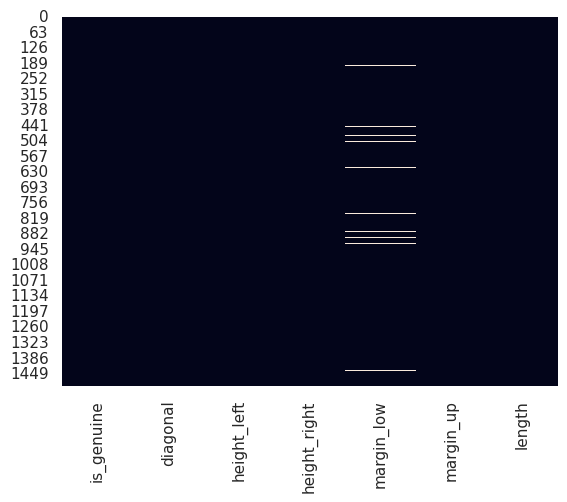

In [8]:
sns.heatmap(df.isna(), cbar=False)

## Analyse Fond

### Target

In [9]:
df["is_genuine"].value_counts(normalize=True)

True     0.666667
False    0.333333
Name: is_genuine, dtype: float64

### Visualiser les Features

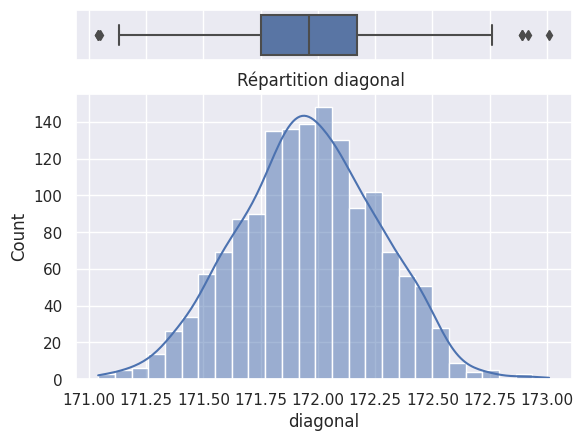

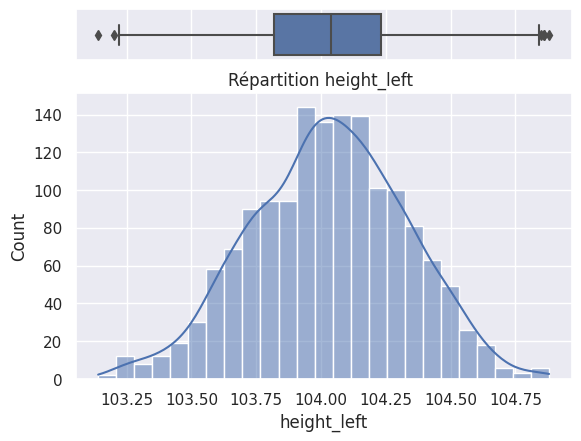

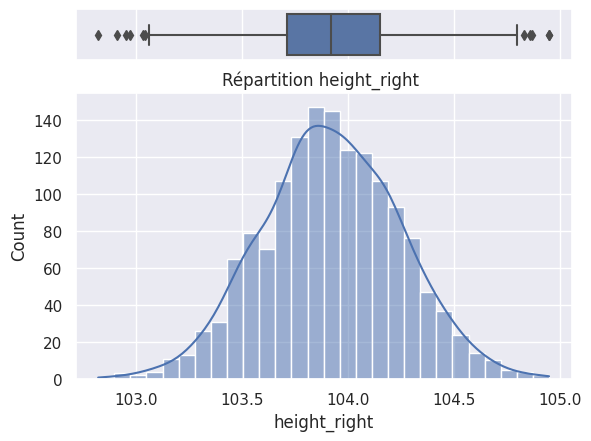

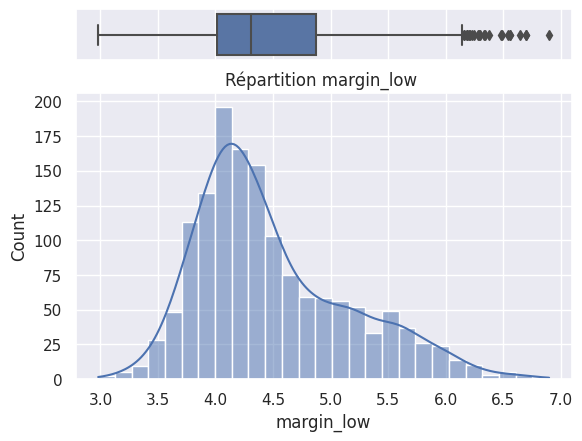

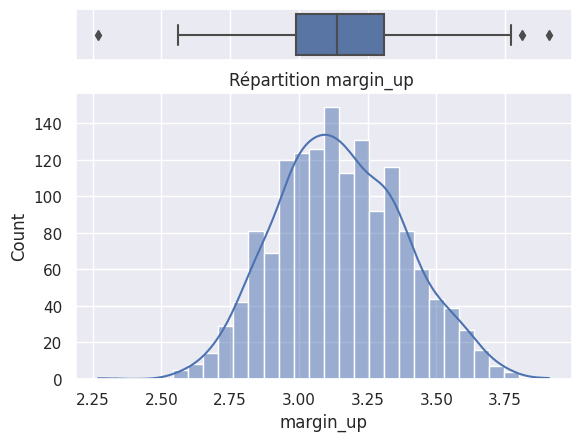

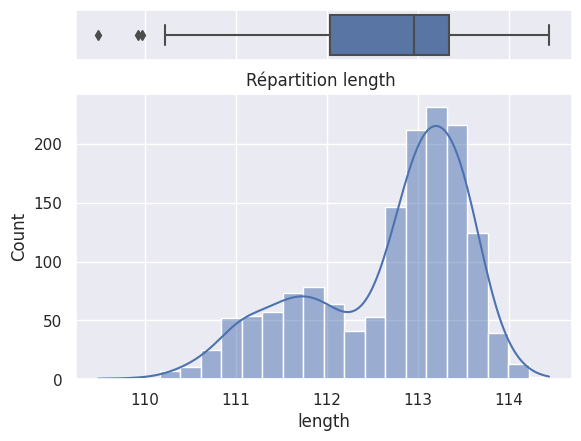

In [10]:
for i in df.select_dtypes('float'):
  f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios":(.15, .85)})
  sns.boxplot(data= df, x= i, ax=ax_box)
  sns.histplot(data= df, x= i, ax=ax_hist, kde= True)
  plt.title(f"Répartition {i} ")
  ax_box.set(xlabel="")
  ax_hist.set(xlabel=i)

In [11]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


### Relation entre Target et Features

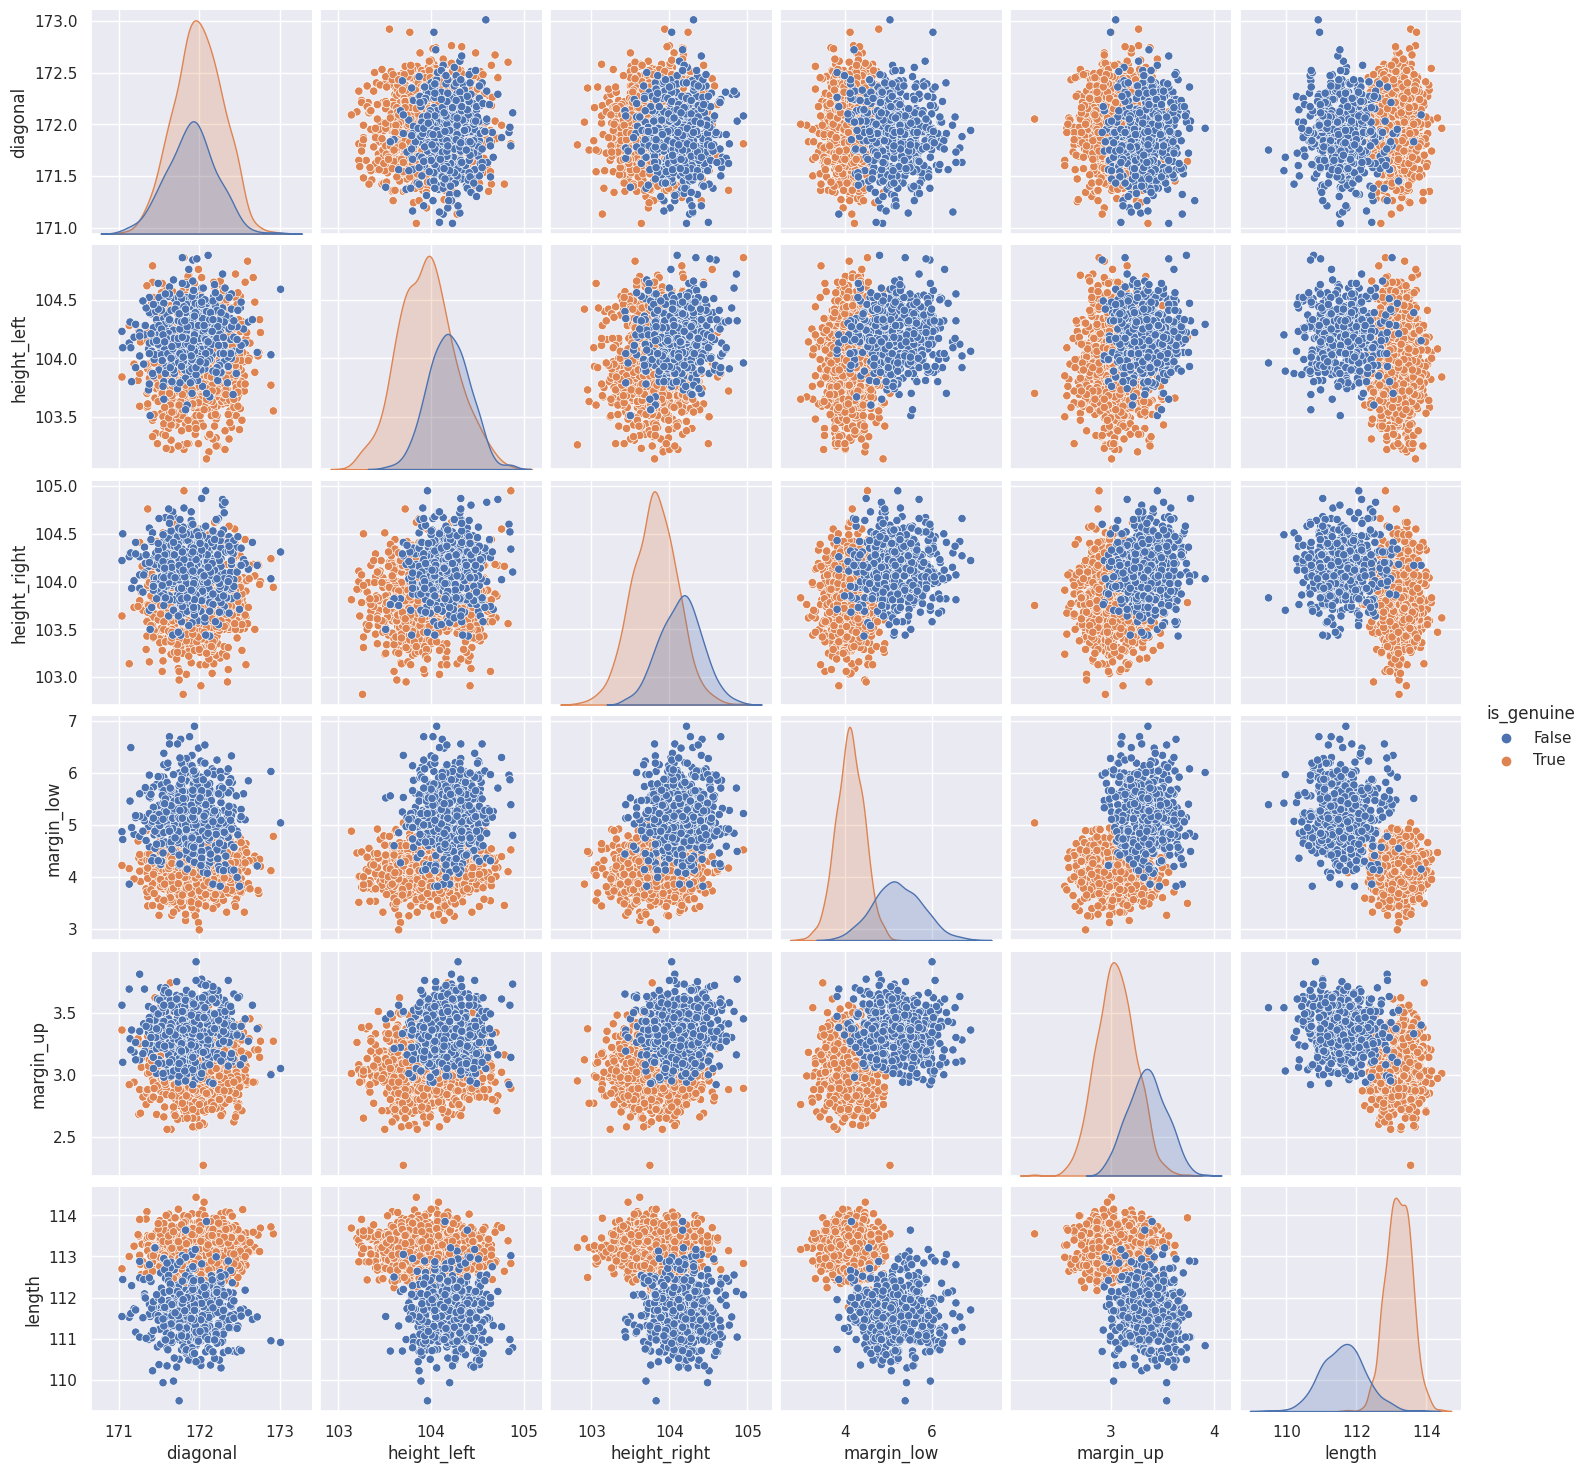

In [12]:
sns.pairplot(df, hue="is_genuine")

### Identifier Outliers

In [13]:
df.std(ddof=0)

is_genuine      0.471405
diagonal        0.305093
height_left     0.299362
height_right    0.325519
margin_low      0.663586
margin_up       0.231736
length          0.872439
dtype: float64

In [14]:
dfqtt= df.drop(columns ="is_genuine", axis=1)
Q1= dfqtt.quantile(0.25)
Q3= dfqtt.quantile(0.75)
IQ = Q3-Q1
Min= Q1-(1.5*IQ)
Max= Q3+(1.5*IQ)
Min

diagonal        171.1200
height_left     103.2050
height_right    103.0500
margin_low        2.7325
margin_up         2.5100
length          110.0650
dtype: float64

In [15]:
liste =("diagonal", "height_left","height_right", "margin_low", "margin_up", "length" )

for i in liste:
  print(i,"Outliers Min", df[df[i]<=Min[i]].shape)
  print(df[df[i]<=Min[i]])
  print(" \n")
  print(i,"Outliers Max", df[df[i]>=Max[i]].shape)
  print(df[df[i]>=Max[i]])
  print(" \n \n \n")

diagonal Outliers Min (3, 7)
      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
729         True    171.04       103.84        103.64        4.22       3.36   
1142       False    171.04       104.23        104.22        4.87       3.56   
1388       False    171.05       104.09        104.50        4.72       3.10   

      length  
729   112.70  
1142  111.54  
1388  112.44  
 

diagonal Outliers Max (4, 7)
      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
828         True    172.92       103.55        103.94        4.78       3.27   
842         True    172.89       103.77        104.24        4.12       3.01   
1022       False    172.89       104.03        104.03        6.03       3.00   
1277       False    173.01       104.59        104.31        5.04       3.05   

      length  
828   113.55  
842   113.72  
1022  110.95  
1277  110.91  
 
 
 

height_left Outliers Min (2, 7)
     is_genuine  diagonal  height_left  hei

## 1eres Hypothèses = 

hypothèses= 
*   Élément de liste
*   Élément de liste

Pistes de modélisation =



# III. PREPROCESSING <a class="anchor" id="III"></a>

## Split des données

In [17]:
trainset, testset = train_test_split(df, test_size= 0.2, random_state=0) 

In [18]:
trainset.is_genuine.value_counts(normalize=True)

True     0.664167
False    0.335833
Name: is_genuine, dtype: float64

In [19]:
testset.is_genuine.value_counts(normalize=True)

True     0.676667
False    0.323333
Name: is_genuine, dtype: float64

## Exploration des 2 datasets

In [20]:
trainset.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      33
margin_up        0
length           0
dtype: int64

In [21]:
testset.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      4
margin_up       0
length          0
dtype: int64

In [22]:
# Définir les colonnes
target = ["encoder"] 
drop_col =[] 
features = ["diagonal", "height_left", "height_right", "margin_up","length"]

# preprocessong à faire
numNaN = ["margin_low"]
catNaN= []
cat = ["is_genuine"]
Text= []
TextNaN= []

# Créer une liste regroupant toutes ces listes
liste_all_listes =[target, drop_col, features, numNaN, catNaN, cat,Text, TextNaN ]

In [23]:
# Vérifier qu'il n'y a pas d'anomalies
def Verif (listes, df):
  set_nos_col = set()
  for liste in listes:
    for col in liste :  # dans chaque liste 
      if col in set_nos_col: # Vérifier si la variable est en double
        print(f'doublon {col} dans les colonnes')  #alerter
      set_nos_col.add(col) 
   
  print("si pas de lignes au-dessus signifie pas de doublon")  
  set_colonnes_originales = set(df.columns)
  mal_ecrit= set_nos_col - set_colonnes_originales   # identifier les Variables mal orthographiées.
  col_manquantes =set_colonnes_originales - set_nos_col # identifier les Variables oubliées.
  print('colonne avec erreur', mal_ecrit)
  print('colonnes manquantes', col_manquantes) 

In [24]:
Verif(liste_all_listes, df)

si pas de lignes au-dessus signifie pas de doublon
colonne avec erreur {'encoder'}
colonnes manquantes set()


## Séparer Features X de la Variable Target y

In [97]:
X = trainset.drop([
  #  "encoder", 
    "is_genuine"], axis ='columns')
X_test = testset.drop([
  #  "encoder", 
    "is_genuine"], axis ='columns')

In [98]:
y = trainset['is_genuine']
y_test = testset['is_genuine']
X.shape, y.shape

((1200, 6), (1200,))

In [27]:
Verif(liste_all_listes, X)

si pas de lignes au-dessus signifie pas de doublon
colonne avec erreur {'encoder', 'is_genuine'}
colonnes manquantes set()


## Pipeline de preprocessing

### Target

In [99]:
Target_encoder = LabelEncoder()     #Target_encoder = LabelBinarizer()
Y= Target_encoder.fit_transform(y)
Y_test = Target_encoder.fit_transform(y_test)

0 = False
1 = True

### Regression Linéaire NaN

In [29]:
NumNan = make_pipeline(SimpleImputer(strategy='mean') )

In [30]:
# Regression linéaire pour les NaN

### Pipeline

In [31]:
preprocessing = make_column_transformer(
  #  ('drop', target), 
  #  ('drop',drop_col), 
    ('passthrough', features),
    (NumNan,numNaN),
  #  ('drop',catNaN), 
  #  ('drop',cat),
  #  ('drop',Text),
  #  ('drop',TextNaN),
   )

In [32]:
test= SimpleImputer(strategy='mean')
preprocessing_X=test.fit_transform(X)

# IV. MACHINE LEARNING <a class="anchor" id="IV"></a>

## Création Pipelines des Modèles

In [138]:
knn_pipe = Pipeline([
                     ('preprocessing', preprocessing), 
                     ('knn', KNN(n_neighbors=5))
                     ],verbose=True)

In [34]:
ridge_pipe = Pipeline([
                      ('preprocessing', preprocessing),
                      ('ridge', RidgeClassifier()),])

In [35]:
rf_pipe = Pipeline([
                      ('preprocessing', preprocessing),
                      ('rf', RandomForest(random_state=777)),])

In [139]:
knn_pipe.fit(X, Y)

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['diagonal', 'height_left',
                                                   'height_right', 'margin_up',
                                                   'length']),
                                                 ('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  ['margin_low'])])),
                ('knn', KNeighborsClassifier())],
         verbose=True)

## CROSS VALIDATION pour Evaluer les Pipelines

### Création CrossValidation

In [37]:
cross_val_folds = KFold(n_splits= 5, shuffle=True,random_state=1)

### Evaluation des modèles

In [38]:
cv_score= cross_val_score(knn_pipe, X,Y, cv= cross_val_folds, scoring='balanced_accuracy' )
print(cv_score)
cv_score.mean(), cv_score.std()


[0.98765432 0.98026316 0.9905653  0.98051948 0.98      ]


(0.9838004510831417, 0.004434773490336768)

In [39]:
cv_score= cross_val_score(ridge_pipe, X,Y, cv= cross_val_folds, scoring='balanced_accuracy' )
print(cv_score)
cv_score.mean(), cv_score.std()


[0.98148148 0.98684211 0.98423618 0.98051948 0.98      ]


(0.9826158498707812, 0.002569472233269822)

In [40]:
cv_score= cross_val_score(rf_pipe, X,Y, cv= cross_val_folds, scoring='balanced_accuracy' )
print(cv_score)
cv_score.mean(), cv_score.std()


[0.98765432 0.99342105 0.9905653  0.98701299 0.98777778]


(0.989286286884767, 0.0024016226537696794)

## Optimiser avec GridSearch

### Création de la GridSearch

In [41]:
knn = {}
knn['pipeline'] =Pipeline([
                          ('preproc', preprocessing),
                          ('knn', KNN())
                          ])

## grille pour la pipeline KNN
knn['hyperparametres']= {}
knn['hyperparametres']['knn__n_neighbors']= [1,3,5,7,9,13,7,21,27,29]
knn['hyperparametres']['knn__weights']= ['uniform','distance']

## GridSearch pour la pipeline
knn['gridsearch'] =GridSearchCV(estimator=knn['pipeline'],
                                param_grid= knn['hyperparametres'],
                                scoring='balanced_accuracy',
                                cv =cross_val_folds)

In [ ]:
ridge = {}
ridge['pipeline'] =Pipeline([
                          ('preproc', preprocessing),
                          ('ridge', ridge())
                          ])

## grille pour la pipeline ridge
ridge['hyperparametres']= {}
ridge['hyperparametres']['ridge__n_neighbors']= [1,3,5,7,9,13,7,21,27,29]
ridge['hyperparametres']['ridge__weights']= ['uniform','distance']

## GridSearch pour la pipeline
ridge['gridsearch'] =GridSearchCV(estimator=ridge['pipeline'],
                                param_grid= ridge['hyperparametres'],
                                scoring='balanced_accuracy',
                                cv =cross_val_folds)

In [55]:
rf = {}
rf['pipeline'] =Pipeline([
                          ('preproc', preprocessing),
                          ('rf', RandomForest())
                          ])

## grille pour la pipeline rf
rf['hyperparametres']= {}
rf['hyperparametres']['rf__n_estimators']= [10,33,150 ]
rf['hyperparametres']['rf__max_features']= ["Sqrt", None, 0.1, 0.66]
rf['hyperparametres']['rf__max_depth']= [None, 2,10]
rf['hyperparametres']['rf__min_samples_split']= [2, 10]




## GridSearch pour la pipeline
rf['gridsearch'] =GridSearchCV(estimator=rf['pipeline'],
                                param_grid= rf['hyperparametres'],
                                scoring='balanced_accuracy',
                                cv =cross_val_folds)

### Trouver les meilleurs hyperparamètres

In [46]:
knn['gridsearch'].fit(X,Y)
print(knn['gridsearch'].best_params_)
print(knn['gridsearch'].best_score_)

{'knn__n_neighbors': 13, 'knn__weights': 'uniform'}
0.984911562194253


In [49]:
ridge['gridsearch'].fit(X,Y)
print(ridge['gridsearch'].best_params_)
print(ridge['gridsearch'].best_score_)

{'ridge__alpha': 0.1}
0.9826158498707812


In [56]:
rf['gridsearch'].fit(X,Y)
print(rf['gridsearch'].best_params_)
print(rf['gridsearch'].best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packa

{'rf__max_depth': 10, 'rf__max_features': 0.66, 'rf__min_samples_split': 10, 'rf__n_estimators': 150}
0.9906552460926026


## Pipeline Final

### Création pipeline

In [61]:
pipeline_final = make_pipeline(preprocessing, 
                               RandomForest(
                                  max_depth= 10, 
                                  max_features= 0.66, 
                                  min_samples_split= 10,
                                  n_estimators= 150))

### Evaluation 

In [109]:
pipeline_final.fit(X,Y)
Y_pred=pipeline_final.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        97
           1       0.99      0.98      0.99       203

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



In [107]:
pipeline_final.score(X_test, Y_test)

0.9833333333333333

### Erreur

In [115]:
print(confusion_matrix(Y_test, Y_pred))

[[ 96   1]
 [  4 199]]


vrai faux= 96          Faux vrai = 1
faux faux= 4           Vrai vrai = 199

In [126]:
miss = testset[(Y_test != Y_pred)]
miss

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
54,True,172.02,103.58,103.80,3.95,3.46,112.40
1083,False,171.85,103.60,103.82,4.60,3.21,112.50
670,True,172.27,104.29,104.22,3.89,3.53,113.50
4,True,171.73,104.28,103.46,4.04,3.48,112.54
980,True,172.12,104.08,104.49,4.09,3.56,113.50


### Learning curve

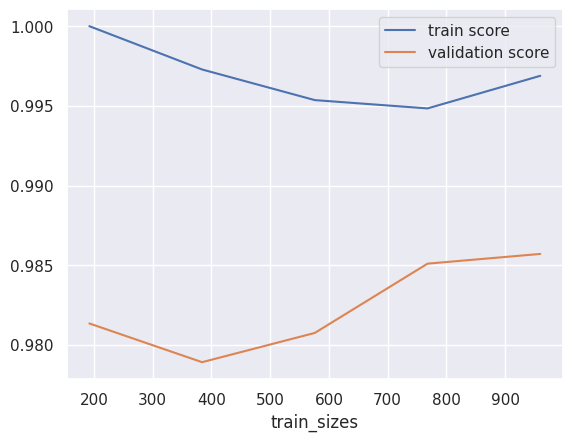

In [117]:
N, train_score, val_score = learning_curve(pipeline_final, X, Y, scoring='balanced_accuracy', train_sizes=np.linspace(0.2, 1.0, 5), cv=5)
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.xlabel('train_sizes')
plt.legend()

# V. Validation

## importer le nouveau jeu de données

In [151]:
t= "/content/drive/MyDrive/P10/billets_production.csv"

In [152]:
nouveau= pd.read_csv(t, sep="," )

## Appliquer le modèle

In [153]:
pipeline_final.predict(nouveau)

array([0, 0, 0, 1, 1])

# V. AUTOML

## instal auto ML

In [66]:
!pip install tpot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stopit: filename=stopit-1.1.2-py3-none-any.whl size=11954 sha256=17888d1f8343f47b7923b675128db1e79a1ec81a0bcd53fad165db1acb843cc8
  Stored in directory: /root/.cache/pip/wheels/af/f9/87/bf5b3d565c2a007b4dae9d8142dccc85a9f164e517062dd519
Successfully built stopit


In [69]:
from tpot import TPOTClassifier

## Mise en place AUTO ML

In [71]:
X_cleaned = preprocessing.fit_transform(X,Y)
automl = TPOTClassifier(generations= 2, population_size=50,
                        scoring = 'balanced_accuracy',
                        cv= cross_val_folds,
                        config_dict= 'TPOT sparse',
                        verbosity= 2,
                        random_state=777,
                        n_jobs= -1)

In [72]:
automl.fit(X_cleaned, Y)

Optimization Progress:   0%|          | 0/150 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9864883035790861

Generation 2 - Current best internal CV score: 0.9880204640999569

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.25, verbosity=0)


TPOTClassifier(config_dict='TPOT sparse',
               cv=KFold(n_splits=5, random_state=1, shuffle=True),
               generations=2, n_jobs=-1, population_size=50, random_state=777,
               scoring='balanced_accuracy', verbosity=2)

In [73]:
automl.export('automl.py')
!cat automl.py

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=777)

# Average CV score on the training set was: 0.9880204640999569
exported_pipeline = XGBClassifier(learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.25, verbosity=0)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 777)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [76]:
xgb = XGBClassifier(learning_rate=0.1, max_depth=7, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.25, verbosity=0)


In [77]:
xgb_pipeline = make_pipeline(preprocessing, 
                             xgb)

In [81]:
score= cross_val_score(xgb_pipeline, X, Y, cv= cross_val_folds, scoring= 'balanced_accuracy')

In [83]:
score.mean(), score.std()

(0.9873884294679222, 0.004635530656586088)